# Analysis of clusters in sample S3

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")


/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


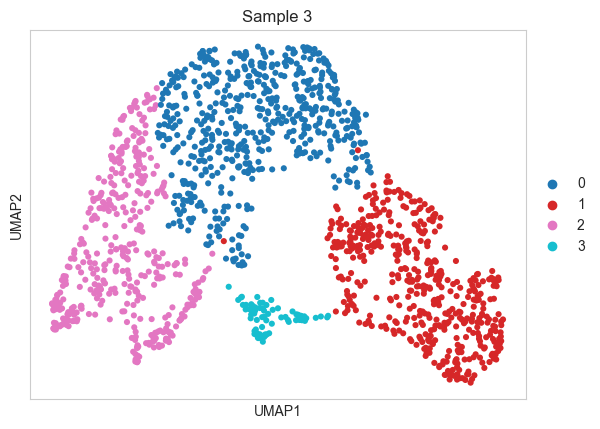

In [4]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[grou

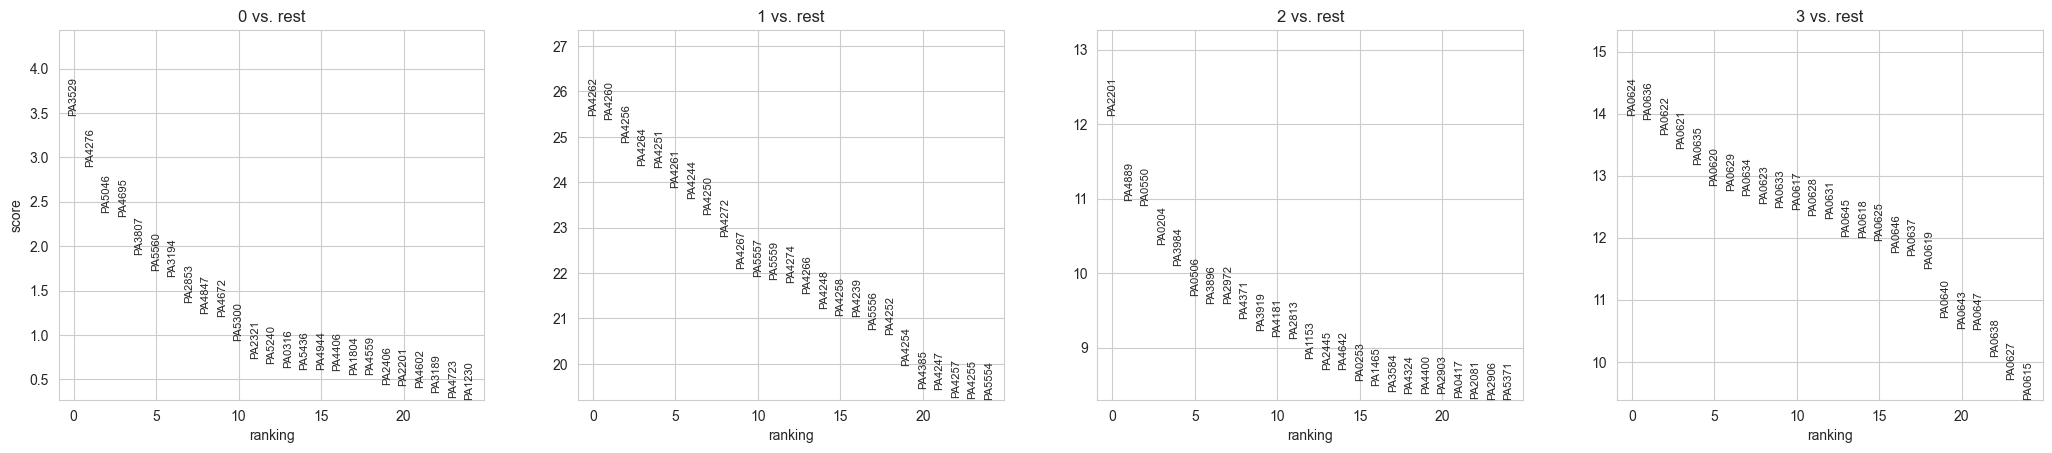

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [6]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB a

## Find optimal correlation matrix scaling and generate synthetic null data

In [225]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

KeyboardInterrupt: 

In [7]:
importlib.reload(cd)

data_gen_noscale, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)


xmin = 1.2360679772046799

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [8]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [9]:
data_gene.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,outlier,n_genes,total_counts_norm,total_counts_scale,embedding_reliability,reliability_score,null_reliability_score,leiden_opt
AAACCCAGTGGACCTC-1,395,5.981414,485.0,6.186209,False,395,-5520.855399,-306.783556,trustworthy,0.556917,0.082263,0
AAACCCATCCTGTAGA-1,558,6.326149,863.0,6.761573,False,558,-5537.830350,-352.602239,trustworthy,0.779740,0.377085,1
AAACGCTCAGATTTCG-1,398,5.988961,491.0,6.198479,False,398,-5514.955366,-275.321721,undefined,0.428113,0.189363,0
AAACGCTTCTTTGCTA-1,598,6.395262,1013.0,6.921658,False,598,-5551.147550,-392.325843,trustworthy,0.619388,0.313508,1
AAAGAACCAGTCTGGC-1,897,6.800170,1190.0,7.082549,False,897,-5367.476470,331.842451,undefined,0.435914,0.547812,2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCTCCTCGCAT-1,592,6.385194,924.0,6.829794,False,592,-5548.655895,-368.312233,trustworthy,0.587962,0.109356,1
TTTGGAGCACCGAATT-1,1930,7.565793,5446.0,8.602820,False,1930,-5396.344149,145.205548,undefined,0.094703,0.589108,1
TTTGGAGCAGCAGTTT-1,604,6.405228,748.0,6.618739,False,604,-5441.733687,59.660240,trustworthy,0.605096,0.301052,2
TTTGGTTTCGTTGTGA-1,371,5.918894,470.0,6.154858,False,371,-5557.570027,-420.193534,undefined,0.427874,0.405871,1


In [10]:
data_null_gen.layers["counts"] = data_null_gen.X.copy()


In [11]:
sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [12]:
data_null_gen.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts
AAACCCAGTGGACCTC-1,1259,7.138867,2650.0,7.882692
AAACCCATCCTGTAGA-1,1493,7.309212,2947.0,7.988882
AAACGCTCAGATTTCG-1,526,6.267201,911.0,6.815640
AAACGCTTCTTTGCTA-1,545,6.302619,797.0,6.682109
AAAGAACCAGTCTGGC-1,932,6.838405,1450.0,7.280008
...,...,...,...,...
TTTGATCTCCTCGCAT-1,1014,6.922644,1744.0,7.464510
TTTGGAGCACCGAATT-1,709,6.565265,918.0,6.823286
TTTGGAGCAGCAGTTT-1,443,6.095825,542.0,6.297109
TTTGGTTTCGTTGTGA-1,865,6.763885,1406.0,7.249215


In [13]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

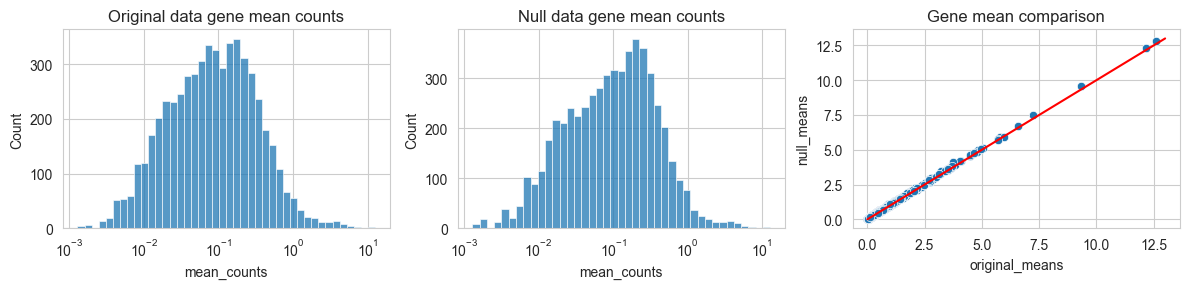

SignificanceResult(statistic=0.9968233661273043, pvalue=0.0)


In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

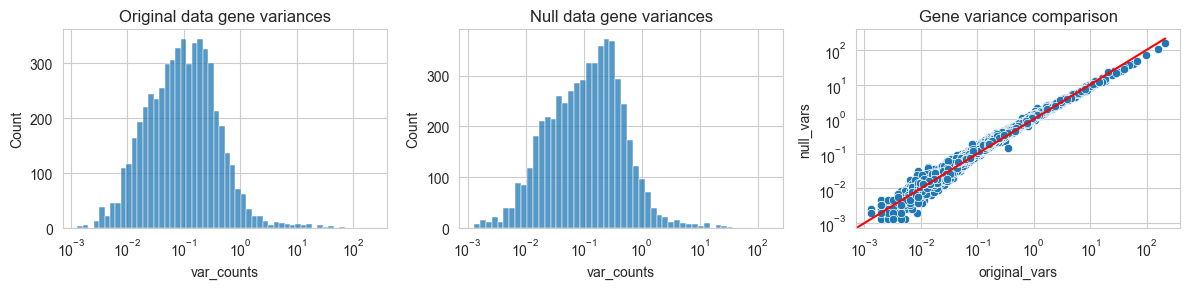

SignificanceResult(statistic=0.9946144943316074, pvalue=0.0)
[[1.         0.99531564]
 [0.99531564 1.        ]]


In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

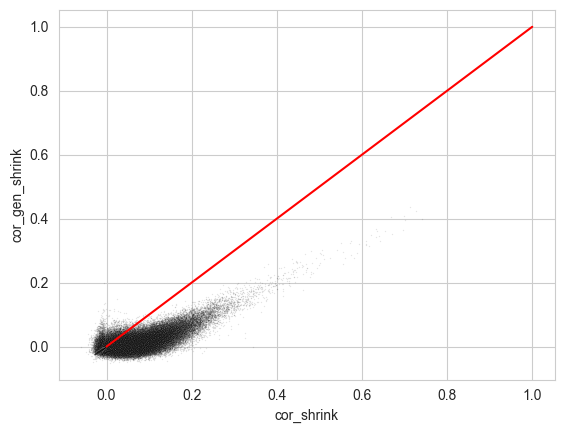

In [16]:
cor_orig = spearmanr(data_gene_nonzero.layers["counts"].toarray()).statistic
cor_orig = pd.DataFrame(cor_orig, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen = spearmanr(data_null_gen.X).statistic
cor_gen = pd.DataFrame(cor_gen, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})
all_cors["ratio"] = all_cors["cor_orig"]/all_cors["cor_gen"]

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1, color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### Process null data

In [17]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')


In [18]:
data_null_gen.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,var_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,
PA0001,729,0.712435,0.537916,52.784974,1100.0,7.003974,0.886218,False,5.938586,5.938586,-8.534099,2.636797,-8.925563,2.754419,0.017341,0.674695,0.340275
PA0002,555,0.523964,0.421315,64.054404,809.0,6.697034,0.732586,False,4.659977,4.659977,-8.493114,2.514288,NaN,NaN,NaN,0.397113,0.366314
PA0003,832,0.913212,0.648784,46.113990,1410.0,7.252054,1.197131,False,6.282301,6.282301,-8.480476,2.698074,-9.048726,2.871205,0.015666,0.785022,0.356160
PA0004,478,0.400907,0.337120,69.041451,619.0,6.429719,0.465569,False,3.563306,3.563306,-8.378329,2.403115,-9.917083,2.885378,0.018295,0.119257,0.387090
PA0005,203,0.141192,0.132073,86.852332,218.0,5.389072,0.141982,False,0.908295,0.908295,-7.070903,1.663479,NaN,NaN,NaN,-1.267227,0.574106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,18,0.012306,0.012231,98.834197,19.0,2.995732,0.013450,False,0.108692,0.108692,-5.858710,0.467120,NaN,NaN,NaN,-3.563440,0.394365
PA5567,180,0.147668,0.137732,88.341969,228.0,5.433722,0.197106,False,0.884657,0.884657,-7.039698,1.646200,NaN,NaN,NaN,-1.306799,0.577075
PA5568,700,0.642487,0.496212,54.663212,992.0,6.900731,0.703791,False,5.688843,5.688843,-8.537665,2.610842,-7.611846,2.307249,0.013207,0.627452,0.346594


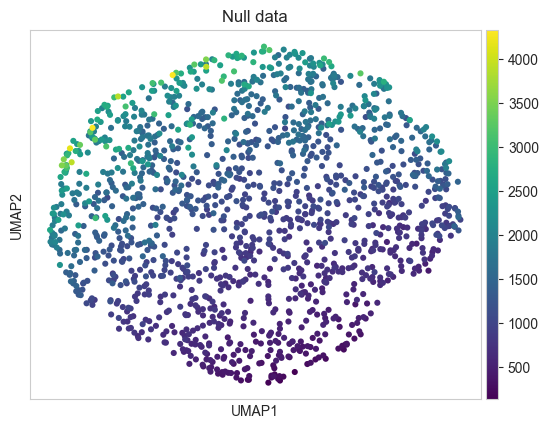

In [19]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [53]:
rng = np.random.default_rng(1234)
seeds = np.random.choice(1000, 10)
print(seeds)

for s in seeds:
    res2 = 0.01
    twoclust = False
    
    while twoclust is False:
        res2 += 0.005
        res2 = np.round(res2, 3)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{s}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{s}"].unique())
        if nclust == 2:
            twoclust = True
            

            
            
    
    

[ 11  56 820 848 442 259 675 205 926 228]


In [54]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
all_pvals = {}

i = 0
for s in seeds:
    print("")
    print(s)
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{s}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{s}"] != "0"]
    
    pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)
    
    
    DEs_log = {}
    pvals_log = {}
    fdr = 0.05
    
    for c in clusters:
        X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
        X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
        p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
        DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
        data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
        data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
        data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
        
        DEs_log[c] = DE_TU
        pvals_log[c] = pval_TU
        print(f"Cluster {c} - DE genes: {len(DEs_log[c])}; Minimum q value: {np.min(pvals_log[c]['q'])}")
        
    all_pvals[i] = pvals_log
    i += 1


11
Cluster 0 - DE genes: 0; Minimum q value: 0.3119383825417201
Cluster 1 - DE genes: 32; Minimum q value: 0.03125
Cluster 2 - DE genes: 5078; Minimum q value: 0.03967696629213483
Cluster 3 - DE genes: 0; Minimum q value: 1.0

56
Cluster 0 - DE genes: 0; Minimum q value: 0.24247128221049363
Cluster 1 - DE genes: 0; Minimum q value: 0.05
Cluster 2 - DE genes: 5094; Minimum q value: 0.04207188160676533
Cluster 3 - DE genes: 0; Minimum q value: 1.0

820
Cluster 0 - DE genes: 0; Minimum q value: 0.11245216367382985
Cluster 1 - DE genes: 0; Minimum q value: 0.125
Cluster 2 - DE genes: 0; Minimum q value: 0.058721183123097
Cluster 3 - DE genes: 0; Minimum q value: 1.0

848
Cluster 0 - DE genes: 0; Minimum q value: 0.7581699346405228
Cluster 1 - DE genes: 64; Minimum q value: 0.024390243902439025
Cluster 2 - DE genes: 52; Minimum q value: 0.022222222222222223
Cluster 3 - DE genes: 0; Minimum q value: 0.1111111111111111

442
Cluster 0 - DE genes: 0; Minimum q value: 0.6134928547690263
Cluster

In [55]:
for i in range(len(seeds)):
    for c in clusters:
        all_pvals[i][c]["run_no"] = i
    
all_pvals_dfs = {}
for c in clusters:
    all_pvals_dfs[c] = pd.concat([all_pvals[i][c] for i in range(len(seeds))])


[None]

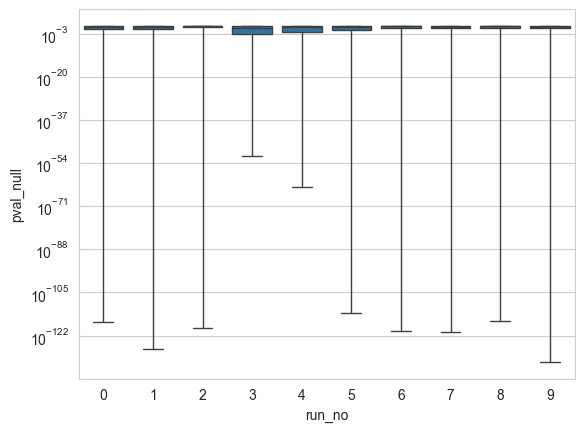

In [56]:
g = sns.boxplot(all_pvals_dfs["0"], x="run_no", y="pval_null")
g.set(yscale="log")

In [57]:
for c in clusters:
    all_pvals_dfs[c]["cluster"] = c
    
total_pvals_df = pd.concat(all_pvals_dfs.values())
print(total_pvals_df)

            pval_data      pval_null  pval_trafo_data  pval_trafo_null  \
PAO1_ID                                                                  
PA3010   3.553747e-11   8.242559e-01        10.449313         0.083938   
PA1271   1.972031e-12   1.885032e-02        11.705086         1.724681   
PA4604   2.278941e-10   8.420686e-01         9.642267         0.074653   
PA3003   4.096580e-10   6.070278e-01         9.387579         0.216791   
PA1529   9.670580e-10   8.684087e-01         9.014547         0.061276   
...               ...            ...              ...              ...   
PA4267   4.433846e-01  1.650841e-106         0.353219       105.782295   
PA4256   6.801165e-01  2.735380e-117         0.167417       116.562982   
PA4262   4.799592e-01  1.735282e-122         0.318796       121.760630   
PA4260   7.310230e-01  1.317758e-127         0.136069       126.880164   
PA4264   6.417799e-01  4.292612e-133         0.192614       132.367278   

                 cs         q  run_no

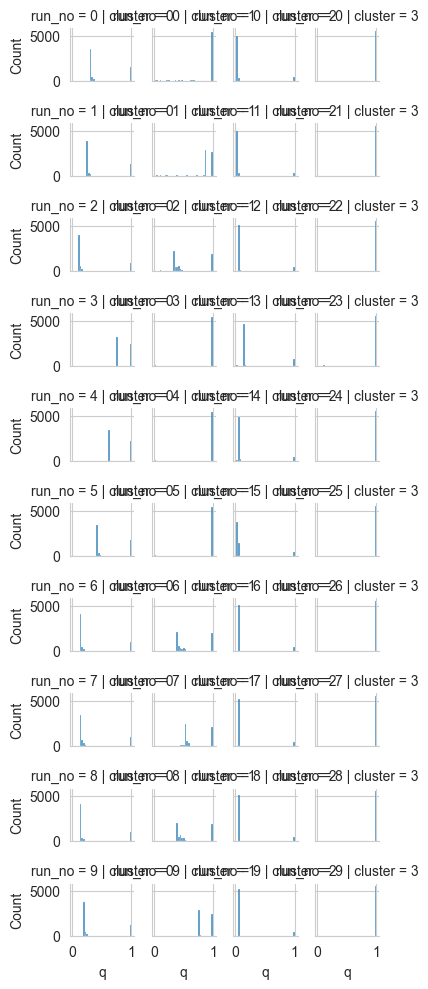

In [97]:
g = sns.displot(data=total_pvals_df, row="run_no", col="cluster", x="q", kind="hist", height=1)
plt.show()

In [59]:
n_small = total_pvals_df[total_pvals_df["pval_null"] < 1e-20].groupby(["cluster", "run_no"]).count()
n_small

pval_data  pval_null  pval_trafo_data  pval_trafo_null  cs   q
cluster run_no                                                                
0       0              68         68               68               68  68  68
        1              74         74               74               74  74  74
        2              88         88               88               88  88  88
        3              18         18               18               18  18  18
        4              46         46               46               46  46  46
        5              61         61               61               61  61  61
        6              85         85               85               85  85  85
        7              80         80               80               80  80  80
        8              84         84               84               84  84  84
        9              78         78               78               78  78  78
1       0              68         68               68               68  68  68
        1              74         74               74               74  74  74
        2              88         88               88               88  88  88
        3              18         18               18               18  18  18
        4              46         46               46               46  46  46
        5              61         61               61               61  61  61
        6              85         85               85               85  85  85
        7              80         80               80               80  80  80
        8              84         84               84               84  84  84
        9              78         78               78               78  78  78
2       0              68         68               68               68  68  68
        1              74         74               74               74  74  74
        2              88         88               88               88  88  88
        3              18         18               18               18  18  18
        4              46         46               46               46  46  46
        5              61         61               61               61  61  61
        6              85         85               85               85  85  85
        7              80         80               80               80  80  80
        8              84         84               84               84  84  84
        9              78         78               78               78  78  78
3       0              68         68               68               68  68  68
        1              74         74               74               74  74  74
        2              88         88               88               88  88  88
        3              18         18               18               18  18  18
        4              46         46               46               46  46  46
        5              61         61               61               61  61  61
        6              85         85               85               85  85  85
        7              80         80               80               80  80  80
        8              84         84               84               84  84  84
        9              78         78               78               78  78  78

In [101]:
small_pval_genes = (total_pvals_df[total_pvals_df["pval_null"] < 1e-20]).reset_index().groupby("PAO1_ID").count().sort_values("pval_data", ascending=False).index
small_pval_genes

Index(['PA2201', 'PA1588', 'PA4935', 'PA4272', 'PA4261', 'PA4385', 'PA4274',
       'PA1777', 'PA4433', 'PA4243',
       ...
       'PA2641', 'PA2743', 'PA1838', 'PA4854', 'PA4847', 'PA4852', 'PA2321',
       'PA4672', 'PA4939', 'PA5049'],
      dtype='object', name='PAO1_ID', length=112)

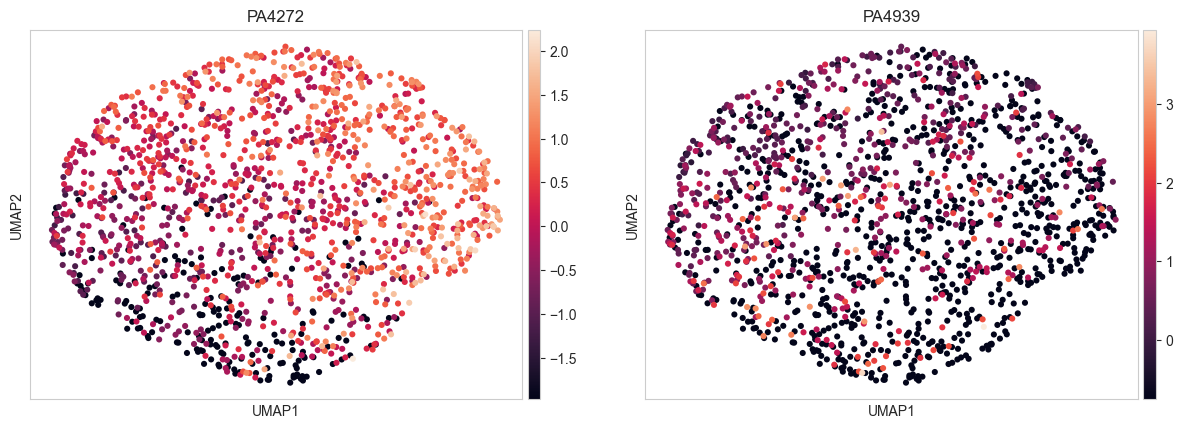

In [62]:
sc.pl.umap(data_null_gen, color=["PA4272", "PA4939"])

In [103]:

data_gene.var.loc[small_pval_genes[:10], :]

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,PAO1_ID,TU_ID,...,is_scd_outlier,mean,std,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA2201,Gene Expression,PA01,635,0.895725,0.639602,58.873057,1383.0,7.232733,PA2201,1511,...,False,1.642961,0.152263,0.895725,3.138738,-2.243013,nb,0.895748,0.491434,0.0
PA1588,Gene Expression,PA01,1454,3.806347,1.569937,5.829016,5877.0,8.678972,PA1588,1113,...,False,1.341326,0.427597,3.806347,17.014960,-13.208613,nb,3.806349,1.903387,0.0
PA4935,Gene Expression,PA01,1225,2.152202,1.148101,20.660622,3323.0,8.108924,PA4935,3323,...,False,1.271481,0.322305,2.152202,6.934736,-4.782534,nb,2.152181,1.525052,0.0
PA4272,Gene Expression,PA01,1475,4.497409,1.704277,4.468912,6944.0,8.845777,PA4272,2875,...,False,1.398359,0.462043,4.497409,24.455952,-19.958543,nb,4.497420,1.740838,0.0
PA4261,Gene Expression,PA01,1472,5.700777,1.902224,4.663212,8802.0,9.082848,PA4261,2868,...,False,1.483306,0.550842,5.700777,48.498549,-42.797771,nb,5.700778,1.327035,0.0
PA4385,Gene Expression,PA01,1166,1.909326,1.067922,24.481865,2948.0,7.989221,PA4385,2951,...,False,1.291877,0.290358,1.909326,5.920535,-4.011208,nb,1.909326,1.432773,0.0
PA4274,Gene Expression,PA01,1431,3.623057,1.531056,7.318653,5594.0,8.629629,PA4274,2877,...,False,1.323826,0.425923,3.623057,18.477085,-14.854028,nb,3.623058,1.621690,0.0
PA1777,Gene Expression,PA01,1468,3.694948,1.546487,4.922280,5705.0,8.649274,PA1777,1228,...,False,1.343570,0.421065,3.694948,14.546192,-10.851244,nb,3.694956,2.123660,0.0
PA4433,Gene Expression,PA01,1103,1.422927,0.884977,28.562176,2197.0,7.695303,PA4433,2977,...,False,1.405357,0.225544,1.422927,2.768671,-1.345744,nb,1.422928,2.328797,0.0


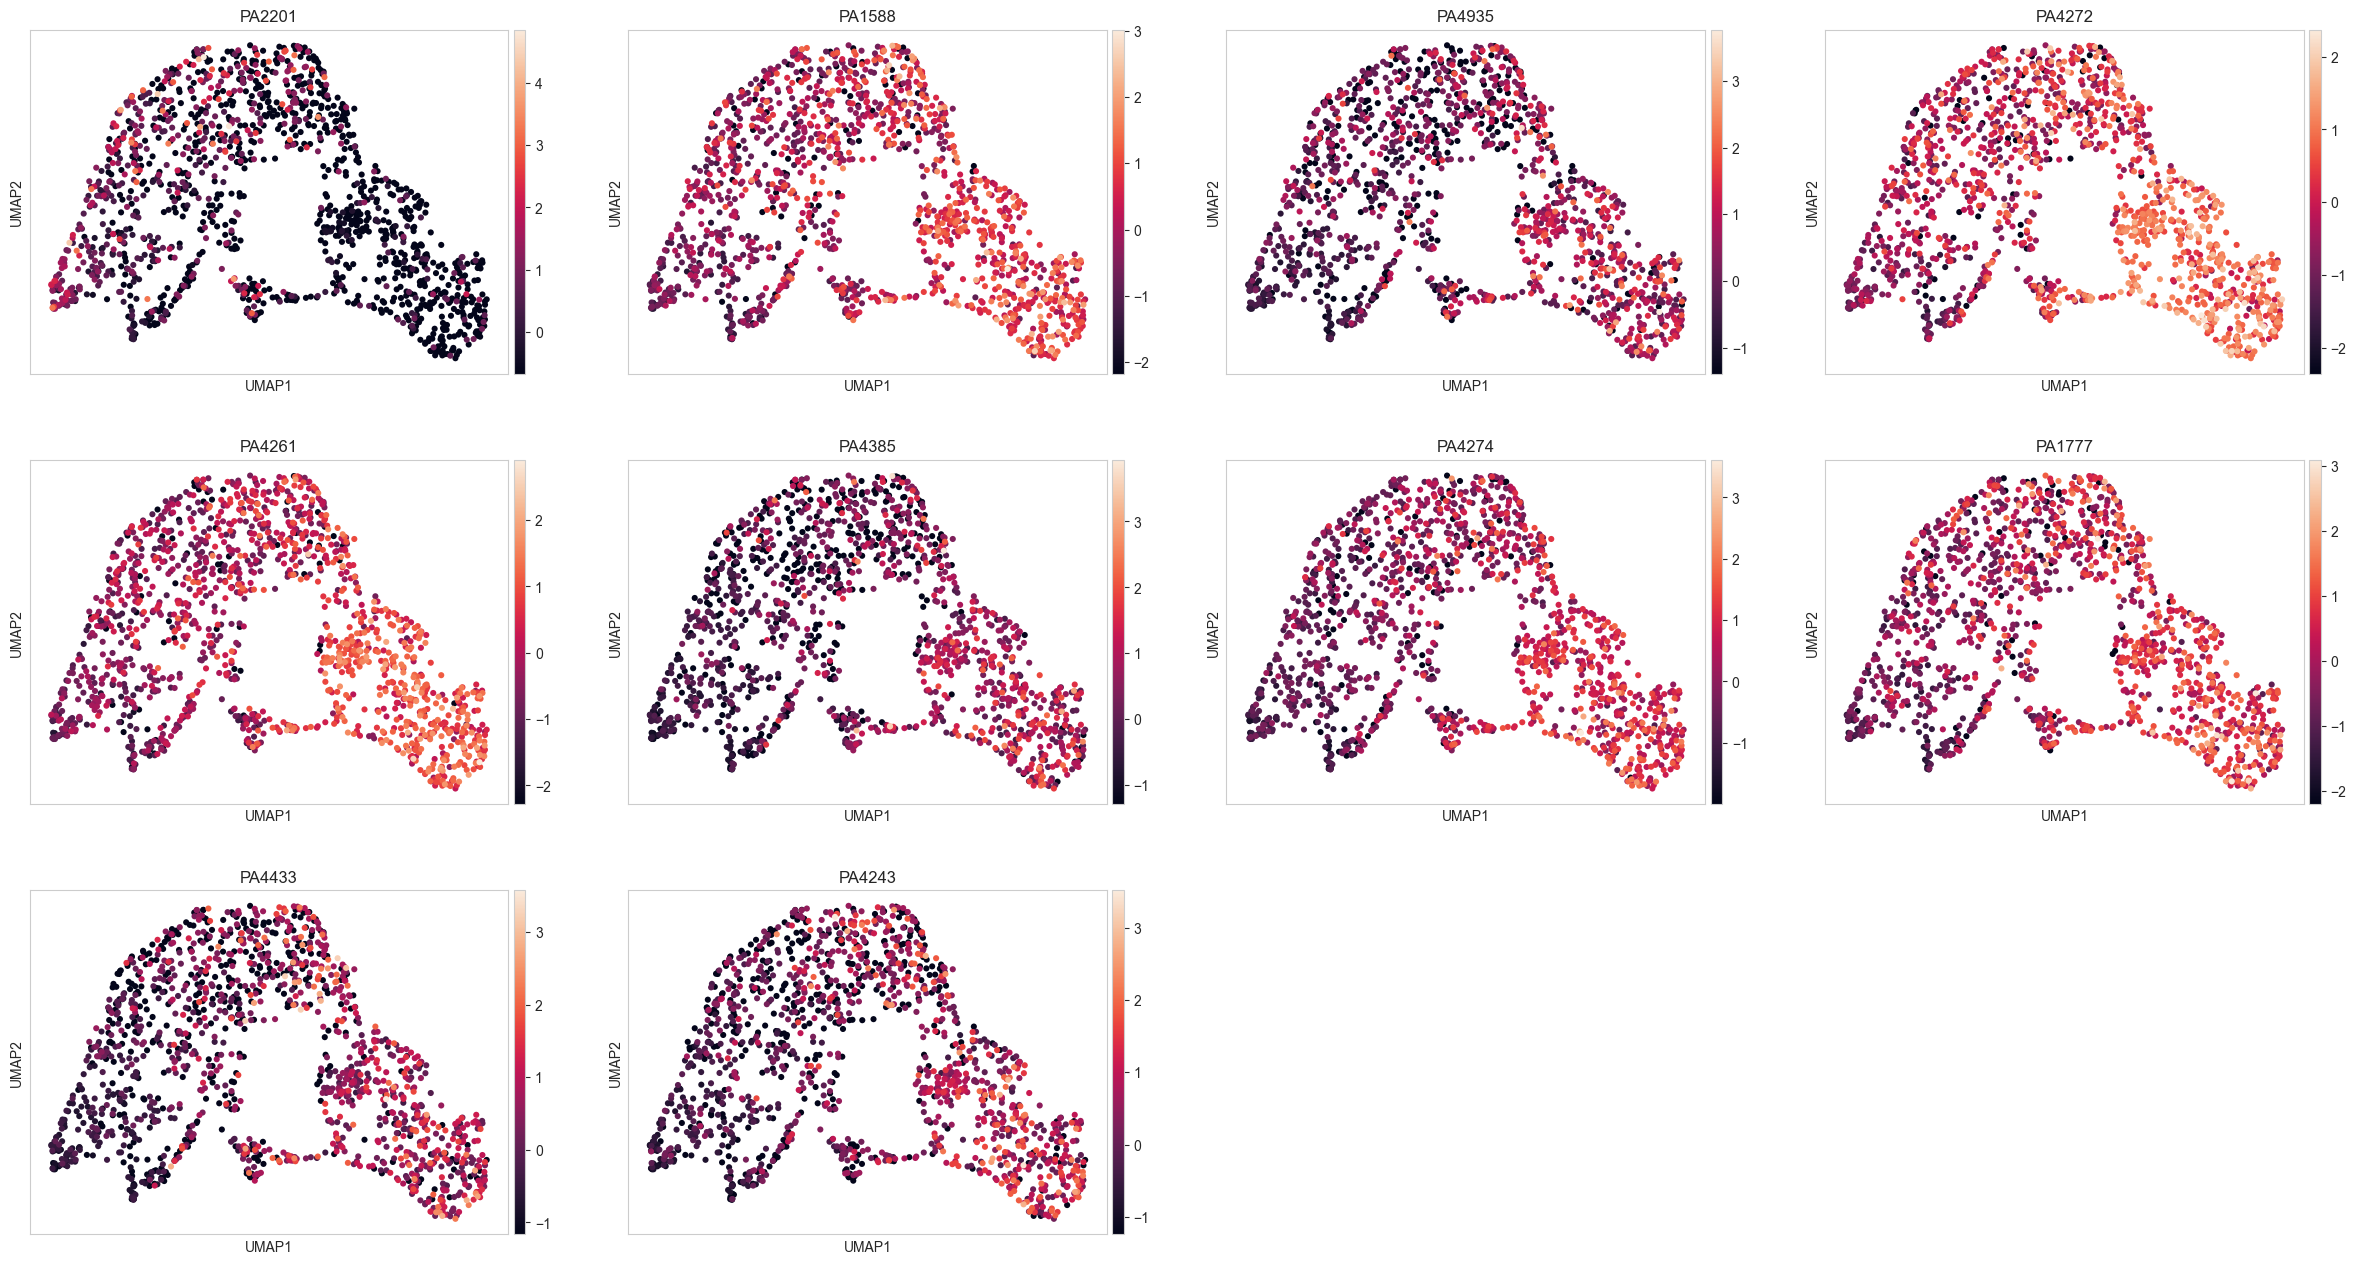

In [104]:
sc.pl.umap(data_gene, color=small_pval_genes[:10])

In [70]:
s = 11
sc.tl.rank_genes_groups(data_null_gen, groupby=f"leiden_{s}", method="t-test")

pd.DataFrame({"pval_null": [data_null_gen.uns["rank_genes_groups"]["pvals"][i][0] for i in range(len(data_null_gen.var.index))]}, index=data_null_gen.var.index)

,pval_null
PAO1_ID,
PA0001,5.063424e-110
PA0002,7.825179e-104
PA0003,3.596974e-101
PA0004,9.176863e-106
PA0005,5.981587e-101
...,...
PA5566,1.678637e-22
PA5567,1.067703e-23
PA5568,1.561909e-30


In [74]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
all_pvals = {}

i = 0
for s in seeds:
    print("")
    print(s)
    # X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{s}"] == "0"]
    # X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{s}"] != "0"]
    
    # pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)
    sc.tl.rank_genes_groups(data_null_gen, groupby=f"leiden_{s}", method="t-test")
    pval_null_gen = pd.DataFrame({"pval_null": [data_null_gen.uns["rank_genes_groups"]["pvals"][i][0] for i in range(len(data_null_gen.var.index))]}, index=data_null_gen.var.index)
    
    DEs_log = {}
    pvals_log = {}
    fdr = 0.05
    
    for c in clusters:
        # X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
        # X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
        p_data = pd.DataFrame({"pval_data": [data_gene_nonzero.uns["rank_genes_groups"]["pvals"][i][int(c)] for i in range(len(data_gene_nonzero.var.index))]}, index=data_gene_nonzero.var.index)
        DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
        data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
        data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
        data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
        
        DEs_log[c] = DE_TU
        pvals_log[c] = pval_TU
        print(f"Cluster {c} - DE genes: {len(DEs_log[c])}; Minimum q value: {np.min(pvals_log[c]['q'])}")
        
    all_pvals[i] = pvals_log
    i += 1


11
Cluster 0 - DE genes: 0; Minimum q value: 0.2474304336926548
Cluster 1 - DE genes: 0; Minimum q value: 0.25
Cluster 2 - DE genes: 0; Minimum q value: 0.06551059730250482
Cluster 3 - DE genes: 0; Minimum q value: 1.0

56
Cluster 0 - DE genes: 0; Minimum q value: 0.1856489284854322
Cluster 1 - DE genes: 0; Minimum q value: 0.6
Cluster 2 - DE genes: 0; Minimum q value: 0.0677671589921807
Cluster 3 - DE genes: 0; Minimum q value: 1.0

820
Cluster 0 - DE genes: 0; Minimum q value: 0.6440809968847352
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 0; Minimum q value: 0.10010842067220817
Cluster 3 - DE genes: 0; Minimum q value: 1.0

848
Cluster 0 - DE genes: 0; Minimum q value: 0.888283378746594
Cluster 1 - DE genes: 84; Minimum q value: 0.023255813953488372
Cluster 2 - DE genes: 396; Minimum q value: 0.0026246719160104987
Cluster 3 - DE genes: 0; Minimum q value: 0.1111111111111111

442
Cluster 0 - DE genes: 0; Minimum q value: 1.0
Cluster 1 - DE genes: 87; Minimum q

[None]

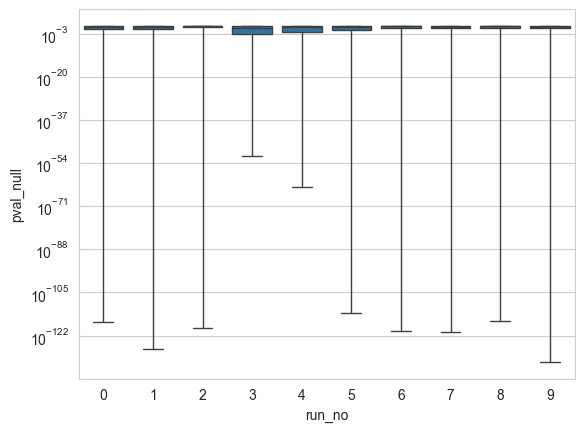

In [75]:
g = sns.boxplot(all_pvals_dfs["0"], x="run_no", y="pval_null")
g.set(yscale="log")

## With seq-depth-scaled data

In [87]:
data_null_gen_scaled = data_null_gen.copy()
data_null_gen_scaled.X = data_null_gen_scaled.layers["counts"]
sc.pp.calculate_qc_metrics(data_null_gen_scaled, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen_scaled.X = np.ceil(data_null_gen_scaled.X / (data_null_gen_scaled.obs["total_counts"].values)[:, np.newaxis] * (data_gene.obs["total_counts"].values)[:, np.newaxis])
data_null_gen_scaled.layers["scaled_counts"] = data_null_gen_scaled.X.copy()

In [88]:
sc.pp.calculate_qc_metrics(data_null_gen_scaled, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen_scaled.var["var_counts"] = np.asarray(np.var(data_null_gen_scaled.X, axis=0)).squeeze()
data_null_gen_scaled.var["mean_counts"] = np.asarray(np.mean(data_null_gen_scaled.X, axis=0)).squeeze()

In [89]:
data_null_gen_scaled.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,var_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,
PA0001,729,0.885363,0.634120,52.784974,1367.0,7.221105,2.418853,False,5.938586,5.938586,-8.534099,2.636797,-8.925563,2.754419,0.017341,0.674695,0.340275
PA0002,555,0.598446,0.469032,64.054404,924.0,6.829794,1.363365,False,4.659977,4.659977,-8.493114,2.514288,NaN,NaN,NaN,0.397113,0.366314
PA0003,832,1.038860,0.712391,46.113990,1604.0,7.380879,2.243309,False,6.282301,6.282301,-8.480476,2.698074,-9.048726,2.871205,0.015666,0.785022,0.356160
PA0004,478,0.495466,0.402438,69.041451,765.0,6.641182,1.033658,False,3.563306,3.563306,-8.378329,2.403115,-9.917083,2.885378,0.018295,0.119257,0.387090
PA0005,203,0.212435,0.192631,86.852332,328.0,5.796058,0.461348,False,0.908295,0.908295,-7.070903,1.663479,NaN,NaN,NaN,-1.267227,0.574106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,18,0.017487,0.017336,98.834197,27.0,3.332205,0.035316,False,0.108692,0.108692,-5.858710,0.467120,NaN,NaN,NaN,-3.563440,0.394365
PA5567,180,0.215674,0.195298,88.341969,333.0,5.811141,0.798692,False,0.884657,0.884657,-7.039698,1.646200,NaN,NaN,NaN,-1.306799,0.577075
PA5568,700,0.797927,0.586635,54.663212,1232.0,7.117206,1.674193,False,5.688843,5.688843,-8.537665,2.610842,-7.611846,2.307249,0.013207,0.627452,0.346594


In [90]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen_scaled, flavor="sctransform")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen_scaled, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen_scaled, target_sum=None, layer=None)
data_null_gen_scaled.X = sps.csr_matrix(np.log(data_null_gen_scaled.X + np.array(data_null_gen_scaled.var["nb_overdisp"] / 4)))
data_null_gen_scaled.layers["vst_counts"] = data_null_gen_scaled.X.copy()
sc.pp.scale(data_null_gen_scaled, max_value=10, zero_center=True)
data_null_gen_scaled.X[np.isnan(data_null_gen_scaled.X)] = 0
sc.tl.pca(data_null_gen_scaled, svd_solver='arpack')
sc.pp.neighbors(data_null_gen_scaled, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen_scaled, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')


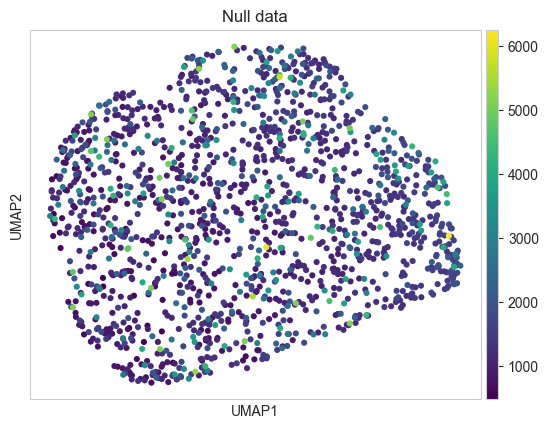

In [91]:
sc.pl.umap(data_null_gen_scaled, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [93]:
rng = np.random.default_rng(1234)
seeds = np.random.choice(1000, 10)
print(seeds)

for s in seeds:
    res2 = 0.01
    twoclust = False
    
    while twoclust is False:
        res2 += 0.005
        res2 = np.round(res2, 3)
        sc.tl.leiden(data_null_gen_scaled, resolution=res2, key_added=f"leiden_{s}", random_state=s)
        nclust = len(data_null_gen_scaled.obs[f"leiden_{s}"].unique())
        if nclust == 2:
            twoclust = True
            


[  1  53 168 124 697 874 874 305 749 732]


In [94]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
all_pvals_scaled = {}

i = 0
for s in seeds:
    print("")
    print(s)
    X_null_gen_0 = data_null_gen_scaled.X[data_null_gen_scaled.obs[f"leiden_{s}"] == "0"]
    X_null_gen_1 = data_null_gen_scaled.X[data_null_gen_scaled.obs[f"leiden_{s}"] != "0"]
    
    pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen_scaled.var.index)
    
    
    DEs_log = {}
    pvals_log = {}
    fdr = 0.05
    
    for c in clusters:
        X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
        X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
        p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
        DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
        data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
        data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
        data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
        
        DEs_log[c] = DE_TU
        pvals_log[c] = pval_TU
        print(f"Cluster {c} - DE genes: {len(DEs_log[c])}; Minimum q value: {np.min(pvals_log[c]['q'])}")
        
    all_pvals_scaled[i] = pvals_log
    i += 1


1
Cluster 0 - DE genes: 0; Minimum q value: 0.7466621020198562
Cluster 1 - DE genes: 85; Minimum q value: 0.013888888888888888
Cluster 2 - DE genes: 75; Minimum q value: 0.014492753623188406
Cluster 3 - DE genes: 22; Minimum q value: 0.045454545454545456

53
Cluster 0 - DE genes: 0; Minimum q value: 0.1519815313582147
Cluster 1 - DE genes: 0; Minimum q value: 0.09090909090909091
Cluster 2 - DE genes: 0; Minimum q value: 0.05845690952073931
Cluster 3 - DE genes: 0; Minimum q value: 1.0

168
Cluster 0 - DE genes: 0; Minimum q value: 0.7221668328348289
Cluster 1 - DE genes: 73; Minimum q value: 0.017241379310344827
Cluster 2 - DE genes: 62; Minimum q value: 0.017241379310344827
Cluster 3 - DE genes: 0; Minimum q value: 0.07142857142857142

124
Cluster 0 - DE genes: 0; Minimum q value: 0.6620489690721649
Cluster 1 - DE genes: 86; Minimum q value: 0.014705882352941176
Cluster 2 - DE genes: 2479; Minimum q value: 0.015151515151515152
Cluster 3 - DE genes: 0; Minimum q value: 1.0

697
Cluste

In [95]:
for i in range(len(seeds)):
    for c in clusters:
        all_pvals_scaled[i][c]["run_no"] = i
    
all_pvals_dfs_scaled = {}
for c in clusters:
    all_pvals_dfs_scaled[c] = pd.concat([all_pvals_scaled[i][c] for i in range(len(seeds))])

[None]

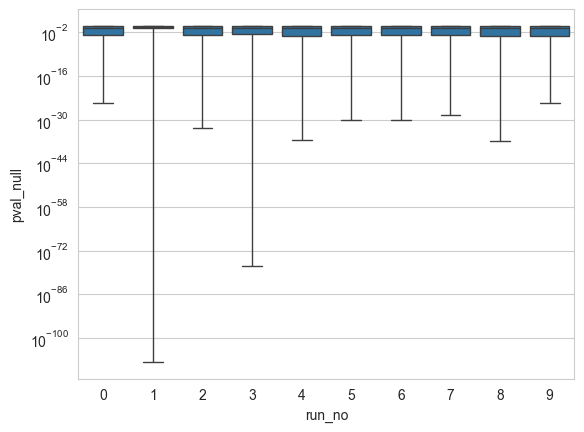

In [96]:
g = sns.boxplot(all_pvals_dfs_scaled["0"], x="run_no", y="pval_null")
g.set(yscale="log")

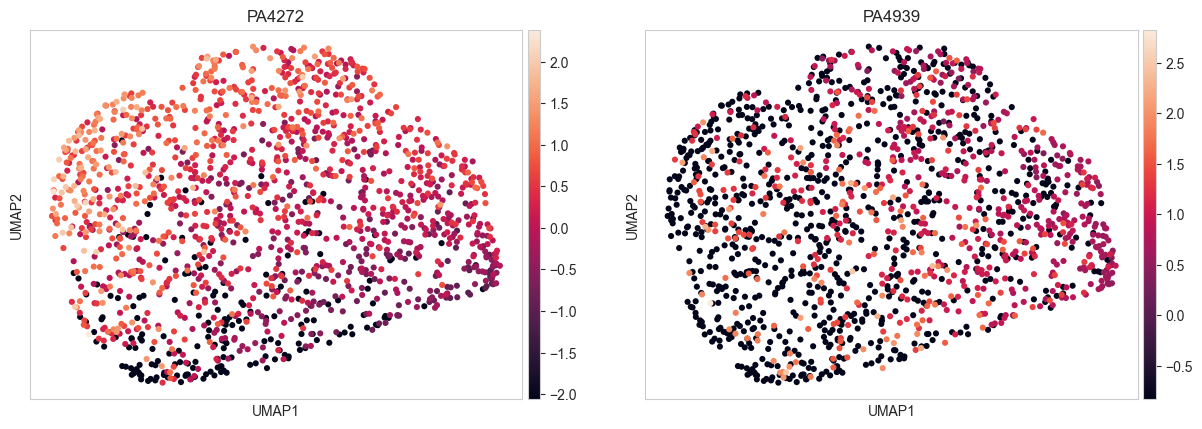

In [105]:
sc.pl.umap(data_null_gen_scaled, color=["PA4272", "PA4939"])